# Fine-Tuning


![Fine tuning. ](../img/finetune.svg)


In earlier chapters, we discussed how to train models on the Fashion-MNIST training dataset, which only has 60,000 images. We also described ImageNet, the most widely used large-scale image dataset in the academic world, with more than 10 million images and objects of over 1000 categories. However, the size of datasets that we often deal with is usually larger than the first, but smaller than the second.

Assume we want to identify different kinds of chairs in images and then push the purchase link to the user. One possible method is to first find a hundred common chairs, take one thousand different images with different angles for each chair, and then train a classification model on the collected image dataset. Although this dataset may be larger than Fashion-MNIST, the number of examples is still less than one tenth of ImageNet. This may result in the overfitting of the complicated model applicable to ImageNet on this dataset. At the same time, because of the limited amount of data, the accuracy of the final trained model may not meet the practical requirements.

In order to deal with the above problems, an obvious solution is to collect more data. However, collecting and labeling data can consume a lot of time and money. For example, in order to collect the ImageNet datasets, researchers have spent millions of dollars of research funding. Although, recently, data collection costs have dropped significantly, the costs still cannot be ignored.

Another solution is to apply transfer learning to migrate the knowledge learned from the source dataset to the target dataset. For example, although the images in ImageNet are mostly unrelated to chairs, models trained on this dataset can extract more general image features that can help identify edges, textures, shapes, and object composition. These similar features may be equally effective for recognizing a chair.

In this section, we introduce a common technique in transfer learning: fine tuning. As shown in `fig_finetune`, fine tuning consists of the following four steps:

1. Pre-train a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the source model, except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will be equally applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset and is therefore not used in the target model.
3. Add an output layer whose output size is the number of target dataset categories to the target model, and randomly initialize the model parameters of this layer.
4. Train the target model on a target dataset, such as a chair dataset. We will train the output layer from scratch, while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.

## Hot Dog Recognition

- fine tune the ResNet model (trained on the ImageNet dataset)

- using a small dataset containing thousands of images, some of which contain hot dogs.

- use the model obtained by fine tuning to identify whether an image contains a hot dog.


Next, we will use a specific example for practice: hot dog recognition. We will fine-tune the ResNet model trained on the ImageNet dataset based on a small dataset. This small dataset contains thousands of images, some of which contain hot dogs. We will use the model obtained by fine tuning to identify whether an image contains a hot dog.

First, import the packages and modules required for the experiment.  Gluon's `model_zoo` package provides a common pre-trained model. If you want to get more pre-trained models for computer vision, you can use the [GluonCV Toolkit](https://gluon-cv.mxnet.io).


In [86]:
%matplotlib inline
from d2l import torch as d2l
from torch import nn
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt


### Obtaining the Dataset

- 1400 hot dog images
- 1400 negative examples (other foods)
- 1000 images used for training


The hot dog dataset we use was taken from online images and contains $1,400$ positive images containing hot dogs and the same number of negative images containing other foods. $1,000$ images of various classes are used for training and the rest are used for testing.

We first download the compressed dataset and get two folders `hotdog/train` and `hotdog/test`. Both folders have `hotdog` and `not-hotdog` category subfolders, each of which has corresponding image files.


In [87]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL+'hotdog.zip', 
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

We create two `ImageFolderDataset` instances to read all the image files in the training dataset and testing dataset, respectively.


In [67]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

The first 8 positive examples and the last 8 negative images are shown below. As you can see, the images vary in size and aspect ratio.


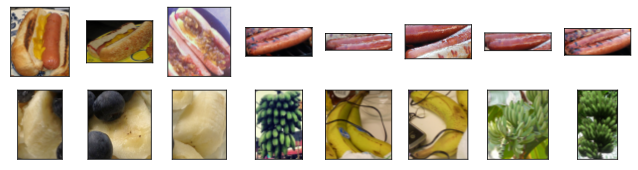

In [88]:
#Some examples:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

During training, we first crop a random area with random size and random aspect ratio from the image and then scale the area to an input with a height and width of 224 pixels. During testing, we scale the height and width of images to 256 pixels, and then crop the center area with height and width of 224 pixels to use as the input. In addition, we normalize the values of the three RGB (red, green, and blue) color channels. The average of all values of the channel is subtracted from each value and then the result is divided by the standard deviation of all values of the channel to produce the output.


In [69]:
# We specify the mean and variance of the three RGB channels to normalize the
# image channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#Imgs augmentation with randomized crop and flip
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Defining and Initializing the Model


- Source model: ResNet-18
- Specify `pretrained=True` to automatically download and load the pre-trained model parameters.  


We use ResNet-18, which was pre-trained on the ImageNet dataset, as the source model. Here, we specify `pretrained=True` to automatically download and load the pre-trained model parameters. The first time they are used, the model parameters need to be downloaded from the Internet.


In [70]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
print(pretrained_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The pre-trained source model instance contains two member variables: `features` and `output`. 

`features`: non fully connected layers
`output`: fully connected layers


The pre-trained source model instance contains two member variables: `features` and `output`. The former contains all layers of the model, except the output layer, and the latter is the output layer of the model. The main purpose of this division is to facilitate the fine tuning of the model parameters of all layers except the output layer. The member variable `output` of source model is given below. As a fully connected layer, it transforms ResNet's final global average pooling layer output into 1000 class output on the ImageNet dataset.



In [76]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

## Build a new NN

- finetune_net: as the pre-trained source model, but the final number of outputs is equal to the number of categories in the target dataset

- `features`: initialized as the corresponding layer of the source model
    - small learning rates, $\eta$,  to "fine-tune" these parameters
-  `output`: randomly initialized
    - large learining rate, e.g. $10\eta$ to learn from scratch 

We then build a new neural network to use as the target model. It is defined in the same way as the pre-trained source model, but the final number of outputs is equal to the number of categories in the target dataset. In the code below, the model parameters in the member variable `features` of the target model instance `finetune_net` are initialized to model parameters of the corresponding layer of the source model. Because the model parameters in `features` are obtained by pre-training on the ImageNet dataset, it is good enough. Therefore, we generally only need to use small learning rates to "fine-tune" these parameters. In contrast, model parameters in the member variable `output` are randomly initialized and generally require a larger learning rate to learn from scratch. Assume the learning rate in the `Trainer` instance is $\eta$ and use a learning rate of $10\eta$ to update the model parameters in the member variable `output`.


In [72]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);
# If `param_group=True`, the model parameters in fc layer will be updated 
# using a learning rate ten times greater, defined in the trainer.

### Fine Tuning the Model

We first define a training function `train_fine_tuning` that uses fine tuning so it can be called multiple times.


In [73]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group: 
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

We set the learning rate in the `Trainer` instance to a smaller value, such as 0.01, in order to fine-tune the model parameters obtained in pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.


loss 0.181, train acc 0.934, test acc 0.941
1004.9 examples/sec on [device(type='cuda', index=0)]


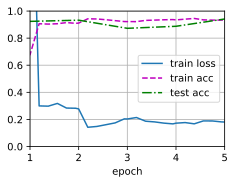

In [27]:
train_fine_tuning(finetune_net, 5e-5)

For comparison, we define an identical model, but initialize all of its model parameters to random values. Since the entire model needs to be trained from scratch, we can use a larger learning rate.


loss 0.361, train acc 0.836, test acc 0.841
1030.7 examples/sec on [device(type='cuda', index=0)]


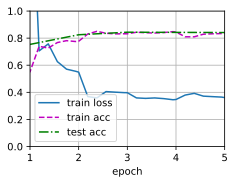

In [63]:
scratch_net = torchvision.models.resnet18 ()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

As you can see, the fine-tuned model tends to achieve higher precision in the same epoch because the initial values of the parameters are better.


## Summary


* Transfer learning migrates the knowledge learned from the source dataset to the target dataset. Fine tuning is a common technique for transfer learning.
* The target model replicates all model designs and their parameters on the source model, except the output layer, and fine-tunes these parameters based on the target dataset. In contrast, the output layer of the target model needs to be trained from scratch.
* Generally, fine tuning parameters use a smaller learning rate, while training the output layer from scratch can use a larger learning rate.




## Exercises

1. Keep increasing the learning rate of `finetune_net`. How does the precision of the model change?
2. Further tune the hyperparameters of `finetune_net` and `scratch_net` in the comparative experiment. Do they still have different precisions?
3. Set the parameters in `finetune_net.features` to the parameters of the source model and do not update them during training. What will happen? 
4. Now that you have available the net finetune_net, how could you use it to evaluate a single image?

# Soluz. es 3. Transfer Learning

In [81]:
#SOLUZ ES. 3

def transfer_learning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group: 
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        for param in params_1x: param.requires_grad = False # THAT'S NEW!!!!
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.466, train acc 0.870, test acc 0.902
2590.8 examples/sec on [device(type='cuda', index=0)]


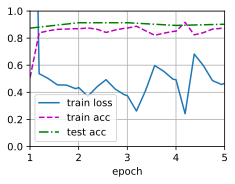

In [82]:
transfer_learning(finetune_net, 5e-5)

# Soluz es 4: Test on a single image

torch.Size([1, 3, 224, 224])
tensor([[-0.1925, -1.1266]], device='cuda:0')
0
hotdog


Text(0.5, 1.0, 'hotdog')

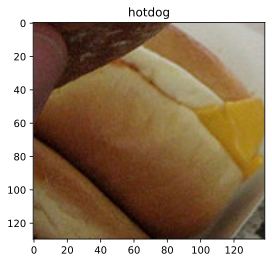

In [151]:
def pre_image(img, model):
   classes = ['hotdog', 'other']
   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   transform_norm = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
   torchvision.transforms.Resize((224,224)),torchvision.transforms.Normalize(mean, std)])
   # get normalized image
   img_normalized = transform_norm(img).float()
   #img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   #img_normalized = img_normalized #.to(device)
   img_normalized = img_normalized.unsqueeze(0).to(device)  # if torch tensor
   print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
      print(output)
      index = output.data.cpu().numpy().argmax()
      print(index)
      #classes = train_ds.classes
      class_name = classes[index]
      print(class_name)
      return class_name
    
#img = Image.open(image_path) #TO LOAD AN IMG FROM FILE SYSTEM
img_hd = test_imgs[100][0]
img_other  = test_imgs[-10][0] #negative index
img = img_hd
eval = pre_image(img, finetune_net)
plt.imshow(img)
plt.title(eval)